In [1]:
!pip3 install pandas
!pip3 install sklearn
!pip3 install xgboost

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
import sklearn.preprocessing
from xgboost import XGBClassifier

In [5]:
train_file = "../data/train.csv"
test_file = "../data/test.csv"


train_data_raw = pd.read_csv(train_file)
test_data_raw = pd.read_csv(test_file)

target = "Survived"


In [6]:

### CLEAN DATA FUNC

def clean_func(train_data):
    
    ## DO IMPUTATION 
    # FARE
    imp_fare = Imputer(missing_values="NaN", strategy="mean")
    imp_fare.fit(train_data[["Fare"]])
    train_data[["Fare"]]=imp_fare.transform(train_data[["Fare"]]).ravel() 

    # Age
    imp=Imputer(missing_values="NaN", strategy="mean")
    imp.fit(train_data[["Age"]])
    train_data[["Age"]]=imp.transform(train_data[["Age"]]).ravel() 
    
    # Filna
    train_data["Cabin"] = train_data["Cabin"].fillna("")

    
    # one hot encoding
    sex_features = pd.get_dummies(train_data["Sex"])
    embarked_features = pd.get_dummies(train_data["Embarked"])
    
    # rename embarked features
    embarked_features = embarked_features.rename(columns={'C': 'embarked_cobh'
                                                        , 'Q': 'embark_queenstown'
                                                        , 'S': 'embark_southampton'})

    # Concat new features
    train_data_extras = pd.concat([train_data,sex_features,embarked_features],axis=1)

    
    
    # HACK - REMOVE T WHICH IS NOT IN TEST LIKELY ERRROR 
    cabin_letters = pd.get_dummies(train_data['Cabin'].map(lambda x: "empty" if len(x)==0 or x[0]=="T" else x[0]))

#    cabin_letters = pd.get_dummies(train_data['Cabin'].map(lambda x: "empty" if len(x)==0 else x[0]))
    cabin_letters.columns = ["Cabin_letter_"+i for i in cabin_letters.columns]
    train_data_extras = pd.concat([train_data_extras,cabin_letters],axis=1)
    

    train_data_extras["Cabin_number"] = train_data['Cabin'].map(lambda x: -99 if len(x)==0 else x.split(" ")[0][1:]) 

    # ONLY RETURN NUMERIC COLUMNS 
    num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']
    train_data_numerics = train_data_extras.select_dtypes(include=num_types)

    return train_data_numerics


## Select only numeric columns

In [7]:
train_data_raw2 = clean_func(train_data_raw)
train_data = train_data_raw2.iloc[:, train_data_raw2.columns != target]
train_data_target = train_data_raw2[target].values


/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(train_data
                              ,train_data_target
                              ,test_size=0.3
                              ,random_state=42)

# Models
- logreg
- random forest

In [9]:
log_reg = LogisticRegression(penalty="l2", dual=False, tol=0.0001, C=1.0
                             , fit_intercept=True, intercept_scaling=1
                             , class_weight=None, random_state=None
                             , solver="liblinear", max_iter=100
                             , multi_class="ovr", verbose=0
                             , warm_start=False, n_jobs=1)

log_reg.fit(X_train,Y_train)




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
Y_pred = log_reg.predict(X_test)

In [11]:
metrics.accuracy_score(Y_test,Y_pred) 

0.8022388059701493

### random forest naive

In [12]:
model_rf = RandomForestClassifier(
n_estimators=100
)

model_rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
# Cross Validation RF

scores = cross_val_score(model_rf, X_train, Y_train, cv=10)
print(scores)

[0.8125     0.79365079 0.90322581 0.83870968 0.77419355 0.77419355
 0.83870968 0.79032258 0.82258065 0.91935484]


In [14]:
pred_rf = model_rf.predict(X_test)
metrics.accuracy_score(Y_test,pred_rf)

0.7873134328358209

# Decision tree

In [36]:
model_decision_tree = RandomForestClassifier(
n_estimators=1
)

model_decision_tree.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
pred_dt = model_decision_tree.predict(X_test)
metrics.accuracy_score(Y_test,pred_dt)

0.7611940298507462

### Random Forest Grid Search

In [15]:
model_rf_gs = RandomForestClassifier()



In [16]:
# parmeter dict
param_grid = dict(
    n_estimators=np.arange(60,101,20)
    , min_samples_leaf=np.arange(2,4,1)
    #, criterion = ["gini","entropy"]
    #, max_features = np.arange(0.1,0.5,0.1)
)
print(param_grid)

{'n_estimators': array([ 60,  80, 100]), 'min_samples_leaf': array([2, 3])}


In [17]:
grid = GridSearchCV(model_rf_gs,param_grid=param_grid,scoring = "accuracy", cv = 5)
grid.fit(train_data, train_data_target)
""

# model_rf.fit(train_data, train_data[target])

''

In [18]:
#print(grid)
# for i in ['params',"mean_train_score","mean_test_score"]:
#     print(i)
#     print(grid.cv_results_[i])
#grid.cv_results_

In [19]:
print(grid.best_params_)
print(grid.best_score_)


{'min_samples_leaf': 3, 'n_estimators': 100}
0.8294051627384961


### XGBOOST

In [20]:
model_xgboost = XGBClassifier(max_depth=7, learning_rate=0.01, n_estimators=20)

In [21]:
model_xgboost.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [22]:
print(metrics.accuracy_score(Y_train,model_xgboost.predict(X_train)))
metrics.accuracy_score(Y_test,model_xgboost.predict(X_test))


0.8860353130016051


0.8246268656716418

## train on full data - can only use estimate from cross val

In [23]:
model_rf_gs = RandomForestClassifier(**grid.best_params_)
model_rf_gs.fit(train_data,train_data_target)
""
#print(**grid.best_params_)



''

### Get params - lin reg

In [24]:
# get parameters
coef = list(log_reg.coef_.ravel())
intercept = log_reg.intercept_

# print them
print(intercept)

coef
for id, i in enumerate(coef):
    print(train_data.columns[id],i)


[1.26215011]
PassengerId 0.00029856426747853105
Pclass -0.6157323114906712
Age -0.029056958218352053
SibSp -0.25731193638503996
Parch -0.0986820701570479
Fare 0.004646482861005507
female 1.9122376324485557
male -0.6500875237127047
embarked_cobh 0.7087607252880808
embark_queenstown 0.4078246018643139
embark_southampton 0.0764307554336727
Cabin_letter_A -0.11837924313536839
Cabin_letter_B 0.25698074917313823
Cabin_letter_C -0.5684826793159974
Cabin_letter_D 0.568167377683216
Cabin_letter_E 1.2341450053378016
Cabin_letter_F 0.7592509600922503
Cabin_letter_G -0.5403264963611312
Cabin_letter_empty -0.3292055647380383


# PREDICT AND STORE OUTPUT

In [25]:
### HACK TO COMPUTE TEST RESULT
test_data = clean_func(test_data_raw)

#test_data[["Age"]]=imp.transform(test_data[["Age"]]).ravel()

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [26]:
## DO IMPUTATION ON FARE
# imp_fare = Imputer(missing_values="NaN", strategy="mean")
# imp_fare.fit(train_data[["Fare"]])

# test_data[["Fare"]]=imp_fare.transform(test_data[["Fare"]]).ravel() # what is ravel???


In [27]:
test_data.isnull().sum()


PassengerId           0
Pclass                0
Age                   0
SibSp                 0
Parch                 0
Fare                  0
female                0
male                  0
embarked_cobh         0
embark_queenstown     0
embark_southampton    0
Cabin_letter_A        0
Cabin_letter_B        0
Cabin_letter_C        0
Cabin_letter_D        0
Cabin_letter_E        0
Cabin_letter_F        0
Cabin_letter_G        0
Cabin_letter_empty    0
dtype: int64

In [28]:
#test_data_y = log_reg.predict(test_data)
test_data_y = log_reg.predict(test_data)


#train_data.head(3)

In [29]:
output = pd.DataFrame(list(zip(list(test_data["PassengerId"]),list(test_data_y))))

output.columns = ["PassengerId","Survived"]

In [30]:
output.to_csv(index=False, path_or_buf= "../data/output.csv")


# output of random forest



In [31]:
def output(data,file_name):
    output = pd.DataFrame(list(zip(list(test_data["PassengerId"]),list(data))))
    output.columns = ["PassengerId","Survived"]
    output.to_csv(index=False, path_or_buf= "../data/{file_name}.csv".format(file_name=file_name))

    


In [32]:
a =list(test_data.columns)
b = list(train_data.columns)

[item for item in b if item not in a]



[]

In [33]:
model_rf_data_y = model_rf.predict(test_data)

output(model_rf_data_y,"predict_rf_1")


In [34]:
model_rf_gs_data_y =model_rf_gs.predict(test_data)
output(model_rf_gs_data_y,"predict_rf_gs_1")

In [35]:
model_xgboost_data_y = model_xgboost.predict(test_data)
output(model_xgboost_data_y,"predict_xgboost_1")


# Try to add noise and different models

In [69]:
models = {
"model_rf_gs" : model_rf_gs
,"model_rf" : model_rf
,"model_xgboost" : model_xgboost
,"model_decision_tree" : model_decision_tree
}


list(models.keys())

#pred_dt = model_decision_tree.predict(X_test)
#metrics.accuracy_score(Y_test,pred_dt)

['model_rf_gs', 'model_rf', 'model_xgboost', 'model_decision_tree']

In [65]:
import numpy as np
np.random.normal(10,10)

#X_test.shape[0]

X_test.dtypes

PassengerId             int64
Pclass                  int64
Age                   float64
SibSp                   int64
Parch                   int64
Fare                  float64
female                  uint8
male                    uint8
embarked_cobh           uint8
embark_queenstown       uint8
embark_southampton      uint8
Cabin_letter_A          uint8
Cabin_letter_B          uint8
Cabin_letter_C          uint8
Cabin_letter_D          uint8
Cabin_letter_E          uint8
Cabin_letter_F          uint8
Cabin_letter_G          uint8
Cabin_letter_empty      uint8
dtype: object

In [80]:
X_test_noise = X_test.copy()


scale = list(range(0,30))

acc = {
"model_rf_gs" : []
,"model_rf" : []
,"model_xgboost" : []
,"model_decision_tree" : []
}


for i,s in enumerate(scale):
    X_test_noise = X_test.copy()
    X_test_noise["Age"] = X_test_noise["Age"] + np.ravel(np.random.normal(loc=0.0, scale=s, size=[X_test.shape[0],1]))
    X_test_noise["Fare"] = X_test_noise["Fare"] + np.ravel(np.random.normal(loc=0.0, scale=s, size=[X_test.shape[0],1]))
    for key in list(models.keys()):
        acc[key].append(metrics.accuracy_score(Y_test, models[key].predict(X_test_noise)))
    
    

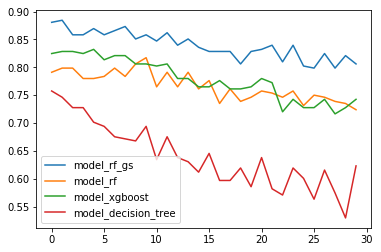

In [81]:
import matplotlib.pyplot as plt

for key in list(models.keys()):
    plt.plot(scale,acc[key],label=key)
    plt.legend()

In [83]:
scale = list(range(0,30))

acc_train = {
"model_rf_gs" : []
,"model_rf" : []
,"model_xgboost" : []
,"model_decision_tree" : []
}

for i,s in enumerate(scale):
    X_train_noise = X_train.copy()
    X_train_noise["Age"] = X_train_noise["Age"] + np.ravel(np.random.normal(loc=0.0, scale=s, size=[X_train.shape[0],1]))
    X_train_noise["Fare"] = X_train_noise["Fare"] + np.ravel(np.random.normal(loc=0.0, scale=s, size=[X_train.shape[0],1]))
    for key in list(models.keys()):
        acc_train[key].append(metrics.accuracy_score(Y_train, models[key].predict(X_train_noise)))
 

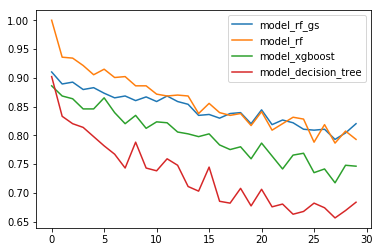

In [84]:
import matplotlib.pyplot as plt

for key in list(models.keys()):
    plt.plot(scale,acc_train[key],label=key)
    plt.legend()